## TODO

- Add disordered regions
- Are there N/C terminal regexes that are not matching correctly?
- Do I require each isoform has at least one PPI?
- vizualize motifs

In [2]:
# TODO: # remove KRTAPS / LCE (only 2% of PPIs)
import re

import numpy as np
import pandas as pd

from ccsblib import huri

from data_loading import (load_isoform_and_paralog_y2h_data,
                          load_valid_isoform_clones,
                          load_annotated_6k_collection,
                          load_human_tf_db,
                          load_tf_families)


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 255)

In [3]:
# looking at Lambert et al. binding mode data, to see if it can help
tfdb = load_human_tf_db()
print(tfdb['Binding mode'].value_counts())
print()
print(tfdb.loc[tfdb['Binding mode'] == 'Obligate heteromer', 'DBD'].value_counts())


Monomer or homomultimer                1564
Obligate heteromer                       49
Low specificity DNA-binding protein      26
Name: Binding mode, dtype: int64

bHLH                25
Unknown              7
bZIP                 6
E2F                  3
SMAD                 2
Nuclear receptor     2
CBF/NF-Y             1
DM                   1
Rel                  1
TBP                  1
Name: DBD, dtype: int64


In [4]:
def load_3did_DDIs():
    fpath = '../../data/external/3did_flat_2022-05.txt'
    domain_pairs = []
    for line in open(fpath, 'r'):
        if line.startswith('#=ID'):
            domain_pairs.append((line.split()[3][1:8], line.split()[4][:7]))
    df = pd.DataFrame(data=domain_pairs, columns=['pfam_a', 'pfam_b'])
    if df.duplicated().any():
        raise UserWarning('unexpected duplicates')
    return df


def load_cofactors():
    cof = pd.read_csv('../../data/external/AnimalTFDB3_Homo_sapiens_TF_cofactors.txt',
                    sep='\t')
    if cof['Symbol'].duplicated().any():
        raise UserWarning('unexpected duplicates')
    return cof

In [5]:
tfs = load_annotated_6k_collection()
ppi = load_isoform_and_paralog_y2h_data()
ppi = ppi.loc[ppi['category'] == 'tf_isoform_ppis', :]
ppi['gene_level_pair'] = ppi['ad_gene_symbol'] + '_' + ppi['db_gene_symbol']
ppi['ad_iso_id'] = ppi['ad_clone_acc'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
# dropping gene with insertion relative to reference geneome
ppi = ppi.loc[~(ppi['ad_gene_symbol'] == 'PCGF6'), :]
iso = load_valid_isoform_clones()
iso = iso.set_index('clone_acc')

# TODO: add in pfam AC for ZF for ZF array
tf_pfam_domains = {tf.name: {dom.accession for iso in tf.cloned_isoforms
                             for dom in iso.aa_seq_features 
                             if dom.category == 'Pfam_domain'}
                   for tf in tfs.values()}
pfam = huri.load_pfam_domains()
partner_domains = pfam.groupby('orf_id')['pfam_accession'].apply(set)
ppi['partner_domains'] = ppi['db_orf_id'].map(partner_domains)
ppi['tf_domains'] = ppi['ad_gene_symbol'].map(tf_pfam_domains)

# check no-overlap with domain motif
ddi = load_3did_DDIs()

def matching_DDIs(row):
    if (
        pd.isnull(row['partner_domains']) or
        pd.isnull(row['tf_domains'])
        ):
        return np.nan
    if (
        len(row['partner_domains']) == 0 or
        len(row['tf_domains']) == 0
    ):
        return np.nan
    matches = ddi.loc[(ddi['pfam_a'].isin(row['partner_domains']) &
                    ddi['pfam_b'].isin(row['tf_domains'])) |
                   (ddi['pfam_a'].isin(row['tf_domains']) &
                    ddi['pfam_b'].isin(row['partner_domains']))].values
    if len(matches) == 0:
        return np.nan
    return frozenset((a, b) for a, b in matches)

ppi['matching_DDI'] = ppi.apply(matching_DDIs, axis=1)

ggi = ppi.loc[:, ['ad_gene_symbol', 'db_gene_symbol', 'db_orf_id', 'matching_DDI']].drop_duplicates()

df = pd.DataFrame(data={tuple(sorted(p)) for ps in ggi.loc[ggi['matching_DDI'].notnull(), 'matching_DDI'].unique() for p in ps},
                  columns=['pfam_a', 'pfam_b'])
df['name_a'] = df['pfam_a'].map(pfam.loc[:, ['pfam_accession', 'domain_name']]
                                    .drop_duplicates()
                                    .set_index('pfam_accession')['domain_name'])
df['name_b'] = df['pfam_b'].map(pfam.loc[:, ['pfam_accession', 'domain_name']]
                                    .drop_duplicates()
                                    .set_index('pfam_accession')['domain_name'])
df['description_a'] = df['pfam_a'].map(pfam.loc[:, ['pfam_accession', 'domain_description']]
                                    .drop_duplicates()
                                    .set_index('pfam_accession')['domain_description'])
df['description_b'] = df['pfam_b'].map(pfam.loc[:, ['pfam_accession', 'domain_description']]
                                    .drop_duplicates()
                                    .set_index('pfam_accession')['domain_description'])
df.sort_values(['name_a', 'name_b']).to_csv('../../data/internal/DDI_for_manual_annotation.tsv', index=False, sep='\t')

# filter and consolidate DDIs

ddi_annot = pd.read_csv('../../data/internal/DDI_manual_annotation.tsv', sep='\t')

valid_ddi_pairs = {frozenset(p) for p in ddi_annot.loc[ddi_annot['to_use'], ['pfam_a', 'pfam_b']].values}
def filter_ddi(pairs):
    if pd.isnull(pairs):
        return np.nan
    passed = frozenset(p for p in pairs if frozenset(p) in valid_ddi_pairs)
    if len(passed) == 0:
        return np.nan
    return passed

ggi['matching_DDI_filtered'] = ggi['matching_DDI'].apply(filter_ddi)

ddi_to_merge = {
    ('PF00170', 'PF07716'): ('PF00170', 'PF00170'),  # bZIP-bZIP
    ('PF00170', 'PF03131'): ('PF00170', 'PF00170'),  # bZIP-bZIP
    ('PF07716', 'PF07716'): ('PF00170', 'PF00170'),  # bZIP-bZIP
    ('PF03131', 'PF03131'): ('PF00170', 'PF00170'),  # bZIP-bZIP
    ('PF00046', 'PF05920'): ('PF00046',	'PF00046'),  # homeobox-homeobox
    ('PF05920', 'PF05920'): ('PF00046',	'PF00046'),  # homeobox-homeobox
    ('PF00989', 'PF14598'): ('PF00989', 'PF00989'),  # PAS-PAS
    ('PF00989', 'PF08447'): ('PF00989', 'PF00989'),  # PAS-PAS
    ('PF00989', 'PF13426'): ('PF00989', 'PF00989'),  # PAS-PAS
    ('PF14598', 'PF14598'): ('PF00989', 'PF00989'),  # PAS-PAS
    ('PF08447', 'PF14598'): ('PF00989', 'PF00989'),  # PAS-PAS
    ('PF08447', 'PF08447'): ('PF00989', 'PF00989'),  # PAS-PAS
}
ggi['matching_DDI_filtered'] = ggi['matching_DDI_filtered'].apply(lambda x: frozenset(ddi_to_merge.get(tuple(sorted(p)), tuple(sorted(p))) for p in x) if pd.notnull(x) else x)

pfam_name = (pfam.loc[:, ['pfam_accession', 'domain_name']]
                 .drop_duplicates()
                 .set_index('pfam_accession')
                 ['domain_name']
                 .to_dict())
pfam_name['PF17725'] = 'YBD'  # one missing from that table because it was added more recently
ggi['DDI'] = ggi['matching_DDI_filtered'].apply(lambda x: ' and '.join(pfam_name[a] + '|' + pfam_name[b] for a, b in x) if pd.notnull(x) else x)

tfdb = load_human_tf_db()
ggi['is_tf_tf'] = ggi['db_gene_symbol'].isin(tfdb['HGNC symbol'].values)
fam = load_tf_families()
ggi['is_same_family_tf'] = (ggi['ad_gene_symbol'].map(fam) == ggi['db_gene_symbol'].map(fam))

dlm = pd.read_csv('../../data/external/elm_interaction_domains.tsv',
                  sep='\t')
elm = pd.read_csv('../../data/external/elm_classes.tsv', header=0, comment='#', sep='\t')
orfs_with_slim_dom = pfam.loc[pfam['pfam_accession'].isin(dlm['Interaction Domain Id']),
                              'orf_id'].unique()
partner_slim_binding_doms = {orf_id: frozenset([d for d in pfam.loc[pfam['orf_id'] == orf_id, 'pfam_accession'].unique() 
                                                if d in dlm['Interaction Domain Id'].unique()]) 
                             for orf_id in orfs_with_slim_dom}
ggi['slim_binding_domains_in_partner'] = ggi['db_orf_id'].map(partner_slim_binding_doms)

reading from cache


In [9]:
print(len(orfs_with_slim_dom), pfam['orf_id'].nunique())
ggi['putative_DMI'] = ggi['db_orf_id'].isin(orfs_with_slim_dom)
print(ggi['putative_DMI'].sum(), ggi['putative_DMI'].mean(), (ggi['DDI'].isnull() & ggi['putative_DMI']).sum())

candidates = (ggi.loc[ggi['putative_DMI'], :]
                                       .groupby(['db_gene_symbol', 'slim_binding_domains_in_partner'])
                                       .size()
                                       .to_frame())
candidates['names'] = (ggi.loc[ggi['putative_DMI'], :]
                                       .groupby(['db_gene_symbol', 'slim_binding_domains_in_partner'])
                                       ['ad_gene_symbol']
                                       .apply(lambda x: ' '.join(sorted(x))))
                                       
print('top slim binding partners:', candidates.sort_values(0, ascending=False).head(25))

print('')

3056 16480
395 0.27856135401974613 329
top slim binding partners:                                                                0  \
db_gene_symbol slim_binding_domains_in_partner                     
PIN1           (PF00397)                                      13   
PRKAA2         (PF00069, PF07714)                             11   
IL16           (PF00595)                                      10   
LNX1           (PF00595)                                       9   
HOXC8          (PF00046)                                       9   
SDCBP          (PF00595)                                       9   
MAPK9          (PF00069, PF07714)                              9   
HOXB5          (PF00046)                                       8   
HOXA1          (PF00046)                                       7   
RXRG           (PF00104)                                       7   
RUNX1T1        (PF01753)                                       6   
DVL3           (PF00595)                          

In [76]:
ggi.loc[ggi['putative_DMI'] & ggi['DDI'].notnull(), 'DDI'].value_counts()

Homeobox|Homeobox                                          22
Hormone_recep|Hormone_recep                                21
Pkinase|zf-C2H2                                            10
Hormone_recep|NR_Repeat and Hormone_recep|Hormone_recep     5
Ank|RHD_dimer                                               3
Homeobox|Pou and Homeobox|Homeobox and Pou|Pou              2
LIM|Ank_2                                                   1
SPRY|SET and fn3|SET                                        1
Homeobox|Pou and Homeobox|Homeobox                          1
Name: DDI, dtype: int64

In [52]:
dlm.loc[dlm['Interaction Domain Id'].isin(['PF07531', 'PF01753', 'PF08788'])]

,ELM identifier,Interaction Domain Id,Interaction Domain Description,Interaction Domain Name
45,LIG_MYND_1,PF01753,zf-MYND,MYND finger
195,LIG_MYND_2,PF01753,zf-MYND,MYND finger
196,LIG_MYND_3,PF01753,zf-MYND,MYND finger


In [10]:
# TFs with slim binding domains
slim_binding_doms = set(dlm['Interaction Domain Id'].unique())
tfs_with_slim_binding_doms = {tf_gene_symbol: frozenset(d for d in doms if d in slim_binding_doms) for tf_gene_symbol, doms in tf_pfam_domains.items()
                              if any(d in slim_binding_doms for d in doms)}
print(len(tfs_with_slim_binding_doms), 'TFs in TFiso1.0 with SLiM binding domain(s)')
ggi['slim_binding_domains_in_tf'] = ggi['ad_gene_symbol'].map(tfs_with_slim_binding_doms)
print(ggi['slim_binding_domains_in_tf'].notnull().sum(), 'gene-level PPI where TF has slim bindig domain')

55 TFs in TFiso1.0 with SLiM binding domain(s)
266 gene-level PPI where TF has slim bindig domain


In [30]:
ggi['slim_binding_domains_in_tf'].value_counts()

(PF00046)    192
(PF00104)     63
(PF00017)      9
(PF09270)      2
Name: slim_binding_domains_in_tf, dtype: int64

In [37]:
# STAT3 has SH2 domain -- but conserved in all isoforms
# RBPJ has BTD domain -- but conserved in all isoforms

In [43]:
ggi.loc[ggi['slim_binding_domains_in_tf'] == frozenset(['PF00104']), 'ad_gene_symbol'].value_counts()

ESRRA    14
ESRRG    11
PPARG    11
NR4A1     4
RXRG      4
NR4A2     4
PPARD     3
HNF4A     3
RARG      3
NR2F2     2
RARB      2
NR1H3     2
Name: ad_gene_symbol, dtype: int64

In [44]:
ggi.loc[ggi['slim_binding_domains_in_tf'] == frozenset(['PF00104']), 'db_gene_symbol'].value_counts()

RXRG       7
NR0B1      5
RXRB       5
NRIP1      3
ESRRG      2
DPF2       2
NCOA1      2
VAX1       2
PSMC5      2
CDKN2D     2
FMNL2      1
RARB       1
SPG21      1
TNNI2      1
RARG       1
LCOR       1
MAPK9      1
ZNF417     1
SDCBP      1
NR2C1      1
KCTD13     1
TSTD2      1
SMARCD3    1
UBE3A      1
ZNF76      1
INO80      1
MSGN1      1
UBXN7      1
ZSWIM3     1
RARA       1
RRP8       1
MPPED2     1
PGBD1      1
CENPX      1
NR1H3      1
PRKCA      1
LONRF1     1
MED25      1
ESRRA      1
FUCA1      1
NR0B2      1
Name: db_gene_symbol, dtype: int64

In [45]:
ggi.loc[ggi['db_gene_symbol'] == 'NR0B1']

,ad_gene_symbol,db_gene_symbol,db_orf_id,matching_DDI,matching_DDI_filtered,DDI,is_tf_tf,is_same_family_tf,putative_DMI,slim_binding_domains_in_tf
2293,PPARD,NR0B1,7215,"((PF00104, PF14046), (PF00104, PF00104), (PF00...","((PF00104, PF14046), (PF00104, PF00104))",Hormone_recep|NR_Repeat and Hormone_recep|Horm...,True,False,True,(PF00104)
2531,PPARG,NR0B1,7215,"((PF00104, PF14046), (PF00104, PF00104), (PF00...","((PF00104, PF14046), (PF00104, PF00104))",Hormone_recep|NR_Repeat and Hormone_recep|Horm...,True,False,True,(PF00104)
3454,HNF4A,NR0B1,7215,"((PF00104, PF14046), (PF00104, PF00104), (PF00...","((PF00104, PF14046), (PF00104, PF00104))",Hormone_recep|NR_Repeat and Hormone_recep|Horm...,True,False,True,(PF00104)
7933,ESRRG,NR0B1,7215,"((PF00104, PF14046), (PF00104, PF00104), (PF00...","((PF00104, PF14046), (PF00104, PF00104))",Hormone_recep|NR_Repeat and Hormone_recep|Horm...,True,False,True,(PF00104)
8474,ESRRA,NR0B1,7215,"((PF00104, PF14046), (PF00104, PF00104), (PF00...","((PF00104, PF14046), (PF00104, PF00104))",Hormone_recep|NR_Repeat and Hormone_recep|Horm...,True,False,True,(PF00104)


In [39]:
dlm.loc[dlm['Interaction Domain Id'] == 'PF09270']

,ELM identifier,Interaction Domain Id,Interaction Domain Description,Interaction Domain Name
259,LIG_CSL_BTD_1,PF09270,BTD,Beta-trefoil DNA-binding domain


In [ ]:
n_ggi = ggi.shape[0]
n_ddi = ggi['matching_DDI'].notnull().sum()
print(n_ggi, 'gene-level PPIs')
print(f'{n_ddi} ({n_ddi/n_ggi:.0%}) mapped to DDIs')
ggi['matching_DDI'].value_counts()

In [132]:
# check the DDIs that were removed
#ggi.loc[ggi['matching_DDI'].notnull() & ggi['matching_DDI_filtered'].isnull()]

In [133]:
n_ggi = ggi.shape[0]
n_ddi = ggi['matching_DDI_filtered'].notnull().sum()
print(f'{n_ddi} ({n_ddi/n_ggi:.0%}) mapped to DDIs, after filtering')

225 (16%) mapped to DDIs, after filtering


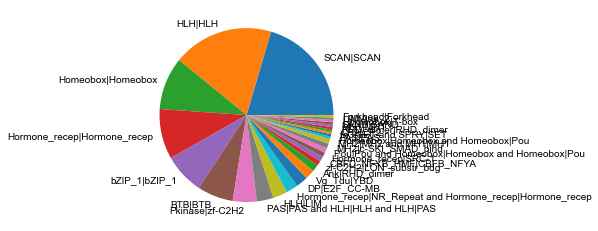

In [235]:
# names
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 1)
ggi['DDI'].value_counts().plot.pie(ax=ax)
ax.set_ylabel('')
fig.savefig('../../figures/DDI-types_pie.pdf',
            bbox_inches='tight')

In [180]:
ggi['is_tf_tf'].mean()

0.31946403385049366

In [227]:
# break down DDI vs DMI etc etc.

<AxesSubplot: ylabel='is_same_family_tf'>

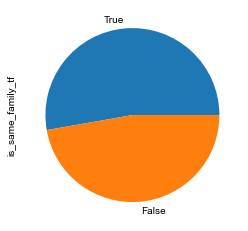

In [229]:
(ggi.loc[ggi['is_tf_tf'], 
        'is_same_family_tf']
.value_counts()
.plot.pie())

In [183]:
cof = load_cofactors()
ggi['is_tf_cf'] = ggi['db_gene_symbol'].isin(cof['Symbol'].values)

In [185]:
(~ggi['is_tf_tf'] & ggi['is_tf_cf']).mean()

0.1459802538787024

In [189]:
from data_loading import load_ppi_partner_categories

cats = load_ppi_partner_categories()

<AxesSubplot: ylabel='category'>

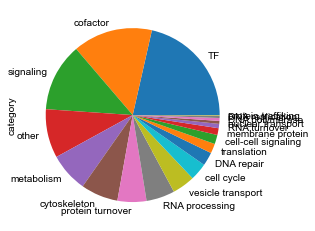

In [231]:
# this is by partner, plot by PPI instead
cats['category'].value_counts().plot.pie()

In [232]:
cats.loc[cats['category'] == 'nuclear transport']

,partner,category,cofactor_type
242,USP2,nuclear transport,NaN
472,NUP58,nuclear transport,NaN
473,NUTF2,nuclear transport,NaN
474,NXT2,nuclear transport,NaN
475,RANBP3,nuclear transport,NaN
476,TNPO2,nuclear transport,NaN


In [233]:
ggi.loc[ggi['db_gene_symbol'].isin(
        cats.loc[cats['category'] == 'nuclear transport',
                 'partner'].values)]

,ad_gene_symbol,db_gene_symbol,matching_DDI,matching_DDI_filtered,DDI,is_tf_tf,is_tf_cf,is_tf_rbp,is_tf_kinase,partner_category,is_same_family_tf
1811,ZBTB7B,USP2,NaN,NaN,NaN,False,False,False,False,other,False
1960,ZBTB44,NXT2,NaN,NaN,NaN,False,False,False,False,other,False
6667,TCF4,NXT2,NaN,NaN,NaN,False,False,False,False,other,False
8025,MEIS2,NUP58,NaN,NaN,NaN,False,False,False,False,other,False
8064,MEIS1,USP2,NaN,NaN,NaN,False,False,False,False,other,False
8724,HOXA1,RANBP3,NaN,NaN,NaN,False,False,False,False,other,False
9076,MEOX1,RANBP3,NaN,NaN,NaN,False,False,False,False,other,False
9509,ZBTB32,TNPO2,NaN,NaN,NaN,False,False,False,False,other,False
9669,RELA,TNPO2,NaN,NaN,NaN,False,False,False,False,other,False


In [213]:
cats.head()

,partner,category,cofactor_type
0,CITED2,cofactor,both
1,DPF2,cofactor,both
2,EMSY,cofactor,both
3,FHL2,cofactor,both
4,HR,cofactor,both


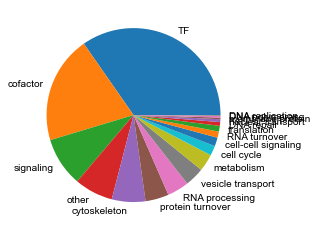

In [234]:
fig, ax = plt.subplots(1, 1)
(ggi['db_gene_symbol']
.map(cats.drop_duplicates('partner').set_index('partner')['category'])
.value_counts()
.plot.pie(ax=ax))
ax.set_ylabel('')
fig.savefig('../../figures/PPIs-gene-level-manual-categories_pie.pdf',
            bbox_inches='tight')

<AxesSubplot: ylabel='partner_category'>

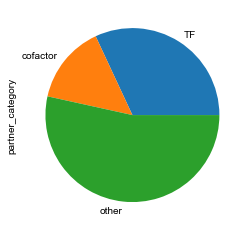

In [222]:
def categorize_PPI_partner(row):
    if row['is_tf_tf']:
        return 'TF'
    elif row['is_tf_cf']:
        return 'cofactor'
    else:
        return 'other'

ggi['partner_category'] = ggi.apply(categorize_PPI_partner, axis=1)
ggi['partner_category'].value_counts()[['TF', 'cofactor', 'other']].plot.pie()

In [200]:
# RNA binding proteins
rbp = pd.read_csv('../../data/external/RBPDB_v1.3.1_proteins_human_2012-11-21.tdt',
                 sep='\t',
                 header=None)
# BUG: there are 10 genes missing names
rbp = set(rbp.loc[rbp.loc[:, 4].notnull(), 4].unique())
ggi['is_tf_rbp'] = ggi['db_gene_symbol'].isin(rbp)
(~ggi['is_tf_tf'] & ~ggi['is_tf_cf'] & ggi['is_tf_rbp']).mean()

0.012693935119887164

In [211]:
# kinase / phosphatase
from Bio import SeqIO

kinase_genes = {r.description.split()[2][len('gene='):] for r in SeqIO.parse('../../data/external/human_kinases.fa', 'fasta')}
ggi['is_tf_kinase'] = ggi['db_gene_symbol'].isin(kinase_genes)
(~ggi['is_tf_tf'] & ~ggi['is_tf_cf'] & ggi['is_tf_kinase']).mean()

0.01904090267983075

In [ ]:
# relation of domain loss to DDI PPI loss

In [108]:
pair = ('PF00023', 'PF16179')
pair = ('PF12796', 'PF16179')
pair = ('PF00010',	'PF00989')
pair = ('PF00505',	'PF00505')

pair = ('PF00989',	'PF00989')
pair = ('PF00989',	'PF14598')
#pair = ('PF00989',	'PF08447')
#pair = ('PF08447',	'PF08447')

# NPAS2	ARNTL
# NPAS2	ARNTL2
# ARNT2	SIM1
# HIF1A	ARNTL

pair = ('PF00170',	'PF00170')

ggi.loc[ggi['matching_DDI'].apply(lambda x: not pd.isnull(x) and pair in x)]

,ad_gene_symbol,db_gene_symbol,matching_DDI
0,ATF2,ATF2,"((PF00170, PF07716), (PF00170, PF00170))"
3,ATF2,FOSL2,"((PF00170, PF07716), (PF00170, PF00170))"
4,ATF2,JDP2,"((PF00170, PF03131), (PF00170, PF07716), (PF00..."
123,CREB5,FOSL2,"((PF00170, PF07716), (PF00170, PF00170))"
124,CREB5,JDP2,"((PF00170, PF03131), (PF00170, PF07716), (PF00..."
1596,FOS,ATF2,"((PF00170, PF07716), (PF00170, PF00170))"
1604,FOS,JUNB,"((PF00170, PF03131), (PF00170, PF07716), (PF00..."
8210,FOSB,JUNB,"((PF00170, PF03131), (PF00170, PF07716), (PF00..."
8797,FOSB,ATF2,"((PF00170, PF07716), (PF00170, PF00170))"


In [112]:
pair = ('PF03166',	'PF03166')
ggi.loc[ggi['matching_DDI'].apply(lambda x: not pd.isnull(x) and pair in x)]

,ad_gene_symbol,db_gene_symbol,matching_DDI
1054,SMAD4,SMAD1,"((PF03166, PF03166), (PF03165, PF03165))"
1055,SMAD4,SMAD9,"((PF03166, PF03166), (PF03165, PF03165))"


In [114]:
pair = ('PF03166',	'PF08782')
ggi.loc[ggi['matching_DDI'].apply(lambda x: not pd.isnull(x) and pair in x)]

,ad_gene_symbol,db_gene_symbol,matching_DDI
1053,SMAD4,SKI,"((PF03166, PF08782), (PF08782, PF03166))"
2380,SMAD3,SKI,"((PF03166, PF08782), (PF08782, PF03166))"


In [118]:
pair = ('PF07714',	'PF00017')
ggi.loc[ggi['matching_DDI'].apply(lambda x: not pd.isnull(x) and pair in x)]

,ad_gene_symbol,db_gene_symbol,matching_DDI
3597,STAT3,BLK,"((PF00017, PF07653), (PF07714, PF00017), (PF00..."
3598,STAT3,BMX,"((PF07714, PF00017), (PF00017, PF00017))"
3600,STAT3,ERBB2,"((PF07714, PF00017))"
3605,STAT3,TXK,"((PF07714, PF00017), (PF00017, PF00017), (PF00..."


In [ ]:
ggi.loc[ggi['matching_DDI'].apply(lambda x: not pd.isnull(x) and ('PF00023', 'PF16179') in x)]

In [245]:
# proportion of gene-level PPIs where the partner has a slim binding domain
# or the TF has a slim binding domain
ggi.head()

,ad_gene_symbol,db_gene_symbol,matching_DDI,matching_DDI_filtered,DDI,is_tf_tf,is_tf_cf,is_tf_rbp,is_tf_kinase,partner_category,is_same_family_tf
0,ATF2,ATF2,"((PF00170, PF07716), (PF00170, PF00170))","((PF00170, PF00170))",bZIP_1|bZIP_1,True,False,False,False,TF,True
3,ATF2,FOSL2,"((PF00170, PF07716), (PF00170, PF00170))","((PF00170, PF00170))",bZIP_1|bZIP_1,True,False,False,False,TF,True
4,ATF2,JDP2,"((PF00170, PF03131), (PF00170, PF07716), (PF00...","((PF00170, PF00170))",bZIP_1|bZIP_1,True,False,False,False,TF,True
73,ATF2,MAPK9,"((PF00069, PF00096))","((PF00069, PF00096))",Pkinase|zf-C2H2,False,False,False,False,other,False
99,TP53,TRIM17,NaN,NaN,NaN,False,False,False,False,other,False


In [3]:
print(ppi.loc[:, ['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().shape[0],
      'gene level PPIs')
print(ppi.loc[ppi['db_orf_id'].isin(orfs_with_slim_dom),
              ['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().shape[0],
      'gene level PPIs involving motif binding domain')

1825 gene level PPIs
511 gene level PPIs involving motif binding domain


In [80]:
dom_slim_ppi = set(ppi.loc[ppi['db_orf_id'].isin(orfs_with_slim_dom),
                       'gene_level_pair'].unique())
pos_ppi = set(ppi.loc[(ppi['Y2H_result'] == True), 'gene_level_pair'].unique())
neg_ppi = set(ppi.loc[(ppi['Y2H_result'] == False), 'gene_level_pair'].unique())
diff_slim_ppi = dom_slim_ppi.intersection(pos_ppi.intersection(neg_ppi))
print(len(diff_slim_ppi), 
      'gene-level PPIs where partner has SLiM binding domain and some isoforms bind and some dont')
print('involving {} TF genes'.format(len({p.split('_')[0] for p in diff_slim_ppi})))

200 gene-level PPIs where partner has SLiM binding domain and some isoforms bind and some dont
involving 53 TF genes


In [11]:
def match_elm_motifs(orfs, elm):
    """Take the ELM motifs file and match the regex to given aa seqs
    Args:
        orfs (Series): amino acid sequences indexed by ORF ID
    Returns:
        DataFrame: one row for each seperate match of a motif to an ORF
    """
    motifs = []
    for elmIdx, elmRow in elm.iterrows():
        # inserting ?: to make groups non-capture
        motifMatches = orfs.str.findall(elmRow['Regex'].replace('(', '(?:'))
        for orfID, matches in zip(motifMatches.index, motifMatches.values):
            for match in matches:
                start = orfs.loc[orfID].find(match)
                # switch from 0 to 1-based indexing
                motifs.append((orfID,
                               elmRow['Accession'],
                               elmRow['ELMIdentifier'],
                               start + 1,
                               start + len(match)))
    motifs = pd.DataFrame(data=motifs,
                          columns=('orf_id', 'region_id', 'ELM_ID', 'start', 'end'))
    motifs['source'] = 'ELM_prediction'
    motifs['type'] = 'SLiM'
    return motifs


slims = match_elm_motifs(iso['aa_seq'], elm)

In [82]:
slims

,orf_id,region_id,ELM_ID,start,end,source,type
0,ARNT2|1/6|08C12,ELME000321,CLV_C14_Caspase3-7,144,148,ELM_prediction,SLiM
1,ARNT2|1/6|08C12,ELME000321,CLV_C14_Caspase3-7,481,485,ELM_prediction,SLiM
2,ARNT2|2/6|09E01,ELME000321,CLV_C14_Caspase3-7,133,137,ELM_prediction,SLiM
3,ARNT2|2/6|09E01,ELME000321,CLV_C14_Caspase3-7,470,474,ELM_prediction,SLiM
4,ARNT2|3/6|10D11,ELME000321,CLV_C14_Caspase3-7,144,148,ELM_prediction,SLiM
...,...,...,...,...,...,...,...
103404,TBX18|3/3|01F09,ELME000009,TRG_PTS1,229,232,ELM_prediction,SLiM
103405,ZNF394|1/3|09F09,ELME000009,TRG_PTS1,558,561,ELM_prediction,SLiM
103406,ZNF418|2/2|04G04,ELME000009,TRG_PTS1,125,128,ELM_prediction,SLiM
103407,ZNF655|3/6|03B05,ELME000009,TRG_PTS1,178,181,ELM_prediction,SLiM


In [12]:
def isoform_specific_regions(gene, subset=None):
    """The name is a bit misleading because it's not specific to one isoform but just
       not common to all isoforms.

    Returns: dict(frozenset: list(str)): isoform IDs and list of contiguous AA sequences
                                         that map to them only 

    """
    algn = gene.genomic_alignment_of_aa_seqs(subset=subset)
    subset_prev = None
    isr = {}
    len_algn = len(list(algn.values())[0])
    for i in range(len_algn):
        subset = frozenset({k for k, v in algn.items() if v[i] != '-'})  # the isoforms that have an aa at that genomic position
        if subset_prev is None:
            if (len(subset) < len(algn)) and (len(subset) > 0):
                start = i
                subset_prev = subset
        else:
            if subset != subset_prev:
                if (len(subset_prev) < len(algn)) and (len(subset_prev) > 0):
                    subseq = (algn[list(subset_prev)[0]][start:i], start, i)
                    isr[subset_prev] = isr.get(subset_prev, []) + [subseq]
                start = i
                subset_prev = subset
            elif  i == (len_algn - 1):
                if (len(subset_prev) < len(algn)) and (len(subset_prev) > 0):
                    subseq = (algn[list(subset_prev)[0]][start:], start, i + 1)
                    isr[subset_prev] = isr.get(subset_prev, []) + [subseq]
                start = i
                subset_prev = subset
    merged = {}
    for iso_subset, subseqs in isr.items():
        merged[iso_subset] = []
        prev_end = np.inf
        prev_subseq = ''
        for subseq, start, end in subseqs:
            if start <= prev_end + 2:
                prev_subseq += subseq
                prev_end = end
            else:
                if prev_subseq != '':
                    merged[iso_subset].append(prev_subseq)
                prev_subseq = subseq
                prev_end = end
        merged[iso_subset].append(prev_subseq)
    return merged


def ppi_tf_gene(data, gene_name):
    tf = data.loc[(data['category'] == 'tf_isoform_ppis') &
                (data['ad_gene_symbol'] == gene_name),
                ['ad_clone_name', 'db_gene_symbol', 'Y2H_result']].copy()
    tf = tf.pivot(index='ad_clone_name',
                  columns='db_gene_symbol',
                  values='Y2H_result')
    return tf


def ppi_linked_isoform_specific_regions(ppi_data, gene):
    """
    For now, do not use cases where there are missing values
    """
    isr = isoform_specific_regions(gene, subset={iso.name for iso in gene.cloned_isoforms})
    ppi = ppi_tf_gene(ppi_data, gene.name)
    ppi_isr = {}
    ppi_iso = {partner: set(ppi.index[ppi[partner]])
               for partner in ppi.columns
               if ppi[partner].notnull().all()}
    for partner, ppi_iso_subset in ppi_iso.items():
        for isr_subset, aa_seqs in isr.items():
            if ppi_iso_subset == isr_subset:
                ppi_isr[partner] = (isr_subset, aa_seqs)
    return ppi_isr

In [13]:
slim_binding_domains = pd.merge(pfam,
                                dlm,
                                how='inner',
                                left_on='pfam_accession',
                                right_on='Interaction Domain Id')
slim_binding_domains = pd.merge(slim_binding_domains,
                                ppi,
                                how='inner',
                                left_on='orf_id',
                                right_on='db_orf_id')
slim_ppis = slim_binding_domains.loc[:, ['ad_gene_symbol', 
                                        'db_gene_symbol',
                                        'pfam_accession',
                                        'domain_name',
                                        'domain_description',
                                        'ELM identifier']].drop_duplicates()
ppi_isr = {}
for gene_name in slim_ppis['ad_gene_symbol'].unique():
    if gene_name not in tfs:
        print(gene_name, 'missing')
        continue
    ppi_isr[gene_name] = ppi_linked_isoform_specific_regions(ppi, tfs[gene_name])
slim_ppis = slim_ppis.loc[slim_ppis.apply(lambda x: x['db_gene_symbol'] in ppi_isr[x['ad_gene_symbol']],
                              axis=1),
              :]
slim_ppis['aa_seq_isr'] = slim_ppis.apply(lambda x: ppi_isr[x['ad_gene_symbol']][x['db_gene_symbol']][1], axis=1)

In [14]:
def isr_contains_slim(row):
    # inserting ?: to make groups non-capture
    if row['ELM identifier'] not in elm['ELMIdentifier'].values:
        #raise UserWarning('Missing ELM entry for: ', row['ELM identifier'])
        print('Missing ELM entry for: ', row['ELM identifier'])
        return False
    regex = elm.loc[elm['ELMIdentifier'] == row['ELM identifier'], 'Regex'].values[0].replace('(', '(?:')
    return any(bool(re.search(regex, aa_seq)) for aa_seq in row['aa_seq_isr'])


slim_ppis['slim_match'] = slim_ppis.apply(isr_contains_slim, axis=1)

Missing ELM entry for:  MOD_PLK
Missing ELM entry for:  MOD_PLK
Missing ELM entry for:  MOD_PLK
Missing ELM entry for:  LIG_CaM_1-26_7
Missing ELM entry for:  LIG_CaM_1-17_6
Missing ELM entry for:  LIG_CaM_1-8-9-10_5
Missing ELM entry for:  LIG_CaM_1-8-14_4
Missing ELM entry for:  LIG_CaM_1-5-10-14_3
Missing ELM entry for:  LIG_CaM_1-8_REV_2
Missing ELM entry for:  LIG_CaM_1-14-15-16_REV_1
Missing ELM entry for:  LIG_CaM_1-26_7
Missing ELM entry for:  LIG_CaM_1-17_6
Missing ELM entry for:  LIG_CaM_1-8-9-10_5
Missing ELM entry for:  LIG_CaM_1-8-14_4
Missing ELM entry for:  LIG_CaM_1-5-10-14_3
Missing ELM entry for:  LIG_CaM_1-8_REV_2
Missing ELM entry for:  LIG_CaM_1-14-15-16_REV_1
Missing ELM entry for:  LIG_CaM_1-26_7
Missing ELM entry for:  LIG_CaM_1-17_6
Missing ELM entry for:  LIG_CaM_1-8-9-10_5
Missing ELM entry for:  LIG_CaM_1-8-14_4
Missing ELM entry for:  LIG_CaM_1-5-10-14_3
Missing ELM entry for:  LIG_CaM_1-8_REV_2
Missing ELM entry for:  LIG_CaM_1-14-15-16_REV_1
Missing ELM e

In [15]:
slim_ppis['slim_match'].sum()

158

In [37]:
slim_ppis.loc[slim_ppis['slim_match'] & (slim_ppis['db_gene_symbol'] == 'TXK')].sort_values('ad_gene_symbol')

,ad_gene_symbol,db_gene_symbol,pfam_accession,domain_name,domain_description,ELM identifier,aa_seq_isr,slim_match
3995,STAT3,TXK,PF00069,Pkinase,Protein kinase domain,MOD_CK1_1,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKP],True
4175,STAT3,TXK,PF00069,Pkinase,Protein kinase domain,MOD_NEK2_1,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKP],True
4343,STAT3,TXK,PF00069,Pkinase,Protein kinase domain,MOD_Plk_4,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKP],True
4439,STAT3,TXK,PF00017,SH2,SH2 domain,LIG_SH2_STAT3,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKP],True
4451,STAT3,TXK,PF00017,SH2,SH2 domain,LIG_SH2_STAT5,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKP],True
4535,STAT3,TXK,PF00017,SH2,SH2 domain,LIG_SH2_STAP1,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKP],True


In [116]:
# use disordered info
slim_ppis

,ad_gene_symbol,db_gene_symbol,pfam_accession,domain_name,domain_description,ELM identifier,aa_seq_isr,slim_match
552,PRRX1,HOXA1,PF00046,Homeobox,Homeobox domain,LIG_HOMEOBOX,[SSSLPRCCLHEGLHNGF],False
555,RFX4,HOXA1,PF00046,Homeobox,Homeobox domain,LIG_HOMEOBOX,[MHCGLLEEPDMDST],False
574,MEIS2,MEIS2,PF00046,Homeobox,Homeobox domain,LIG_HOMEOBOX,[GLQSMPGDYVSQGGPMGMSMAQPSYTPPQMTPHPTQLRHGPPMHSYLPSHPHHPAMMMHGGPPTHPGMTMSAQSPTMLNSVDPNVGGQVMDIHAQ],False
577,MEIS1,MEIS2,PF00046,Homeobox,Homeobox domain,LIG_HOMEOBOX,"[MQ, GLQSMPGEYVARGGPMGVSMGQPSYTQPQMPPHPAQLRHGPPMHTYIPGHPHHPTVMMHGGPPHPGMPMSASSPTVLNTGDPTMSGQVMDIHAQ]",False
585,RFX4,HOXC8,PF00046,Homeobox,Homeobox domain,LIG_HOMEOBOX,[MHCGLLEEPDMDST],False
...,...,...,...,...,...,...,...,...
22031,RFX4,CCNK,PF00134,Cyclin_N,"Cyclin, N-terminal domain",DOC_CyclinA_RxL_1,[MHCGLLEEPDMDST],False
22069,HMBOX1,CCNC,PF00134,Cyclin_N,"Cyclin, N-terminal domain",DOC_CyclinA_RxL_1,[DDSTSHSDHQDPISLAVEMAAVNHTILALARQGANEIKTEALDDD],False
22158,HMBOX1,UBE2Z,PF00179,UQ_con,Ubiquitin-conjugating enzyme,MOD_SUMO_for_1,[DDSTSHSDHQDPISLAVEMAAVNHTILALARQGANEIKTEALDDD],True
22162,HMBOX1,UBE2Z,PF00179,UQ_con,Ubiquitin-conjugating enzyme,MOD_SUMO_rev_2,[DDSTSHSDHQDPISLAVEMAAVNHTILALARQGANEIKTEALDDD],False


In [145]:
slim_ppis.loc[slim_ppis['slim_match'], 'ELM identifier'].value_counts()

MOD_NEK2_1           15
MOD_Plk_4            14
MOD_GSK3_1           13
MOD_ProDKin_1        12
MOD_CK1_1            12
MOD_PKA_2             9
MOD_Plk_1             8
MOD_CK2_1             8
DOC_WW_Pin1_4         5
LIG_SH2_STAT5         4
MOD_CDK_SPxK_1        4
DOC_MAPK_MEF2A_6      3
DOC_MAPK_gen_1        3
LIG_SH3_3             3
MOD_CDK_SPK_2         3
MOD_LATS_1            3
MOD_NEK2_2            3
LIG_SH2_STAT3         3
DOC_PP2B_LxvP_1       3
LIG_SH2_STAP1         3
MOD_CDK_SPxxK_3       2
DOC_MAPK_HePTP_8      2
MOD_PKA_1             2
MOD_SUMO_for_1        1
LIG_NRBOX             1
LIG_EVH1_2            1
CLV_PCSK_FUR_1        1
DOC_CKS1_1            1
LIG_EVH1_1            1
CLV_PCSK_PC1ET2_1     1
TRG_ER_diArg_1        1
CLV_PCSK_KEX2_1       1
LIG_CtBP_PxDLS_1      1
MOD_PK_1              1
MOD_Plk_2-3           1
CLV_PCSK_SKI1_1       1
LIG_MLH1_MIPbox_1     1
LIG_SH2_NCK_1         1
LIG_HCF-1_HBM_1       1
MOD_PKB_1             1
LIG_SH2_SRC           1
DOC_ANK_TNKS_1  

In [146]:
slim_ppis.loc[slim_ppis['slim_match'] & (slim_ppis['ELM identifier'] == 'LIG_SH3_3')]

,ad_gene_symbol,db_gene_symbol,pfam_accession,domain_name,domain_description,ELM identifier,aa_seq_isr,slim_match
2361,FOSB,NCK2,PF00018,SH3_1,SH3 domain,LIG_SH3_3,[VRDLPGSAPAKEDGFSWLLPPPPPPPLPFQTSQDAPPNLTASLFTHSEVQVLGDPFPVVNPSYTSSFVLTCPEVSAFAGAQRTSGSDQPSDPLNSPSLLAL],True
3597,PAX5,STAC,PF00018,SH3_1,SH3 domain,LIG_SH3_3,[MDLEKNYPTPRTSRTGHGGVNQLGGVFVNGRPLPDVVRQRIVELAHQGVRPCDISRQLRVSHGCVSKILGRYYETGSIKPGVIGGSKPKVATPKVVEKIAEYKRQNPT],True
3631,MEIS2,HCK,PF00018,SH3_1,SH3 domain,LIG_SH3_3,"[MAQRYDELPHYGG, GLQSMPGDYVSQGGPMGMSMAQPSYTPPQMTPHPTQLRHGPPMHSYLPSHPHHPAMMMHGGPPTHPGMTMSAQSPTMLNSVDPNVGGQVMDIHAQ]",True


In [1]:
slim_ppis.loc[slim_ppis['ad_gene_symbol'] == 'PBX1']

NameError: name 'slim_ppis' is not defined

In [9]:
# count inside region, count outside region...
slim_ppis['aa_seq_ref_iso'] = slim_ppis['ad_gene_symbol'].apply(lambda x: tfs[x].orfs[0].aa_seq)
slim_ppis['regex'] = slim_ppis['ELM identifier'].map(elm[['ELMIdentifier', 'Regex']]
                                                        .drop_duplicates()
                                                        .set_index('ELMIdentifier')
                                                        ['Regex'].str.replace('(', '(?:'))
# TODO: fix missing regex.
#       Difficult because they don't appear on the website
#       or in the list of (e.g. MOD_PLK). I should email
#       the ELM people.
slim_ppis = slim_ppis.dropna(subset=['regex'])
slim_ppis['match_count_ref_iso'] = slim_ppis.apply(lambda x: len(re.findall(x['regex'], x['aa_seq_ref_iso'])),
                axis=1)
slim_ppis['match_count_isr'] = slim_ppis.apply(lambda x: sum(len(re.findall(x['regex'], s)) for s in x['aa_seq_isr']),
                axis=1)
slim_ppis['aa_seq_len_ref_iso'] = slim_ppis['aa_seq_ref_iso'].str.len()
slim_ppis['isr_len'] = slim_ppis['aa_seq_isr'].apply(lambda x: sum(len(s) for s in x))
slim_ppis['motif_probability'] = slim_ppis['ELM identifier'].map(elm.set_index('ELMIdentifier')['Probability'])

In [53]:
slim_ppis.groupby(['ad_gene_symbol', 'db_gene_symbol'])['match_count_isr'].sum().head(30)

ad_gene_symbol  db_gene_symbol
ATF2            MAPK9              7
CREB5           MAPK9             20
CREBZF          HCFC1              1
                RALBP1             0
ESRRA           VAX1               0
ESRRG           NR0B2              0
FOS             PIN1               4
FOSB            HOMER3             2
                PRKAA2            14
FOXJ2           CSTF2T             0
FOXN4           HOXC8              0
                PIN1               3
                PRKAA2            15
FOXP2           CTBP2              1
                LNX1               1
                PIN1               7
                RNF8               3
                SDCBP              1
HMBOX1          ASB7               0
                CDK18              2
                UBE2Z              1
                VAX1               0
HOXA1           PCSK5             10
IKZF2           ARHGEF5            0
                CDC7               5
                CTBP2              0
       

In [16]:
# per ISR / domain, how many get a match
(slim_ppis.groupby(['ad_gene_symbol', 'db_gene_symbol'])['match_count_isr'].sum() > 0).value_counts()

False    88
True     38
Name: match_count_isr, dtype: int64

In [54]:
slim_ppis.head()

,ad_gene_symbol,db_gene_symbol,pfam_accession,domain_name,domain_description,ELM identifier,aa_seq_isr,slim_match,aa_seq_ref_iso,regex,match_count_ref_iso,match_count_isr,aa_seq_len_ref_iso,isr_len
0,TCF4,KLC3,PF00515,TPR_1,Tetratricopeptide repeat,LIG_TPR,[MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHF...,False,MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHFT...,EEVD$,0,0,671,129
8,TCF4,KLC3,PF00515,TPR_1,Tetratricopeptide repeat,TRG_PTS1,[MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHF...,False,MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHFT...,(?:.[SAPTC][KRH][LMFI]$)|(?:[KRH][SAPTC][NTS][...,0,0,671,129
16,TCF4,KLC3,PF00515,TPR_1,Tetratricopeptide repeat,LIG_APCC_Cbox_2,[MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHF...,False,MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHFT...,DR[YFH][ILFVM][PA]..,0,0,671,129
24,TCF4,KLC3,PF00515,TPR_1,Tetratricopeptide repeat,LIG_APCC_Cbox_1,[MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHF...,False,MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHFT...,[DE]R[YFH][ILFVM][PAG].R,0,0,671,129
545,TCF4,BARHL2,PF00046,Homeobox,Homeobox domain,LIG_HOMEOBOX,[MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHF...,False,MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHFT...,[FY][DEP]WM,0,0,671,129


In [64]:
# for each gene-gene pair, pick random sequence on longest isoform of length of ISR and look for match
gg = slim_ppis.loc[:, ['ad_gene_symbol', 'db_gene_symbol', 'aa_seq_ref_iso', 'isr_len']].drop_duplicates().copy().set_index(['ad_gene_symbol', 'db_gene_symbol'])

def rand_subseq(row):
    rand_start = np.random.randint((len(row['aa_seq_ref_iso']) - row['isr_len']) + 1)
    return row['aa_seq_ref_iso'][rand_start:rand_start + row['isr_len']]

null_dist = []
n_samples = 100
for __ in range(n_samples):
    rand_seq = gg.apply(rand_subseq, axis=1)
    rand_seq = pd.merge(rand_seq.rename('rand_aa_seq').reset_index(),
                        slim_ppis.loc[:, ['ad_gene_symbol', 'db_gene_symbol', 'regex']],
                        how='inner')
    rand_seq['match_count_rand_aa_seq'] = rand_seq.apply(lambda x: len(re.findall(x['regex'], x['rand_aa_seq'])),
                    axis=1)
    null_dist.append((rand_seq.groupby(['ad_gene_symbol', 'db_gene_symbol'])['match_count_rand_aa_seq'].sum() > 0).sum())
real = (slim_ppis.groupby(['ad_gene_symbol', 'db_gene_symbol'])['match_count_isr'].sum() > 0).sum()
n = slim_ppis[['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().shape[0]
print('real =', real, 'out of', n)
print('P =', len([n for n in null_dist if n >= real]) / n_samples)

real =  38 out of 126
P = 0.111


In [66]:
# trying same thing using most specific regex
slim_ppis_spec = slim_ppis.sort_values('motif_probability', ascending=True).drop_duplicates(['ad_gene_symbol', 'db_gene_symbol', 'pfam_accession']).copy()

In [67]:
gg = slim_ppis_spec.loc[:, ['ad_gene_symbol', 'db_gene_symbol', 'aa_seq_ref_iso', 'isr_len']].drop_duplicates().copy().set_index(['ad_gene_symbol', 'db_gene_symbol'])

def rand_subseq(row):
    rand_start = np.random.randint((len(row['aa_seq_ref_iso']) - row['isr_len']) + 1)
    return row['aa_seq_ref_iso'][rand_start:rand_start + row['isr_len']]

null_dist = []
n_samples = 100
for __ in range(n_samples):
    rand_seq = gg.apply(rand_subseq, axis=1)
    rand_seq = pd.merge(rand_seq.rename('rand_aa_seq').reset_index(),
                        slim_ppis_spec.loc[:, ['ad_gene_symbol', 'db_gene_symbol', 'regex']],
                        how='inner')
    rand_seq['match_count_rand_aa_seq'] = rand_seq.apply(lambda x: len(re.findall(x['regex'], x['rand_aa_seq'])),
                    axis=1)
    null_dist.append((rand_seq.groupby(['ad_gene_symbol', 'db_gene_symbol'])['match_count_rand_aa_seq'].sum() > 0).sum())
real = (slim_ppis_spec.groupby(['ad_gene_symbol', 'db_gene_symbol'])['match_count_isr'].sum() > 0).sum()
n = slim_ppis_spec[['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().shape[0]
print('real = ', real, 'out of', n)
print('P =', len([n for n in null_dist if n >= real]) / n_samples)

real =  8 out of 126
P = 0.019


In [72]:
slim_ppis['isr_frac'] = (slim_ppis['isr_len'] / slim_ppis['aa_seq_len_ref_iso'])

In [78]:
(slim_ppis[['ad_gene_symbol', 'db_gene_symbol', 'isr_frac']].drop_duplicates()['isr_frac'] < 0.2).sum()

66

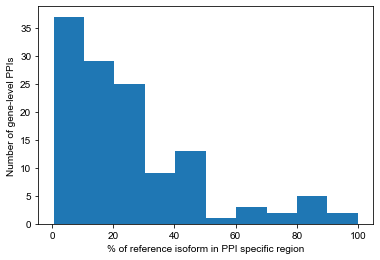

In [99]:
from matplotlib import pyplot as plt
(slim_ppis.loc[: ,['ad_gene_symbol', 'db_gene_symbol', 'isr_frac']].drop_duplicates()['isr_frac'] * 100).plot.hist()
plt.xlabel('% of reference isoform in PPI specific region')
plt.ylabel('Number of gene-level PPIs')
plt.savefig('../../figures/fraction_isr.pdf', bbox_inches='tight')

In [81]:
slim_ppis_spec = slim_ppis.loc[slim_ppis['isr_frac'] <= 0.1, :].copy()
gg = slim_ppis_spec.loc[:, ['ad_gene_symbol', 'db_gene_symbol', 'aa_seq_ref_iso', 'isr_len']].drop_duplicates().copy().set_index(['ad_gene_symbol', 'db_gene_symbol'])

def rand_subseq(row):
    rand_start = np.random.randint((len(row['aa_seq_ref_iso']) - row['isr_len']) + 1)
    return row['aa_seq_ref_iso'][rand_start:rand_start + row['isr_len']]

null_dist = []
n_samples = 100
for __ in range(n_samples):
    rand_seq = gg.apply(rand_subseq, axis=1)
    rand_seq = pd.merge(rand_seq.rename('rand_aa_seq').reset_index(),
                        slim_ppis_spec.loc[:, ['ad_gene_symbol', 'db_gene_symbol', 'regex']],
                        how='inner')
    rand_seq['match_count_rand_aa_seq'] = rand_seq.apply(lambda x: len(re.findall(x['regex'], x['rand_aa_seq'])),
                    axis=1)
    null_dist.append((rand_seq.groupby(['ad_gene_symbol', 'db_gene_symbol'])['match_count_rand_aa_seq'].sum() > 0).sum())
real = (slim_ppis_spec.groupby(['ad_gene_symbol', 'db_gene_symbol'])['match_count_isr'].sum() > 0).sum()
n = slim_ppis_spec[['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().shape[0]
print('real = ', real, 'out of', n)
print('P =', len([n for n in null_dist if n >= real]) / n_samples)

real =  6 out of 37
P = 0.99


In [12]:
print(slim_ppis['match_count_ref_iso'].sum())
print(slim_ppis['match_count_isr'].sum())
print(slim_ppis['match_count_ref_iso'].sum() / slim_ppis['aa_seq_len_ref_iso'].sum())
print(slim_ppis['match_count_isr'].sum() / slim_ppis['isr_len'].sum())

1372
358
0.0022695654906942854
0.002524380010859065


In [183]:
res = slim_ppis.sort_values('motif_probability', ascending=True).drop_duplicates(['ad_gene_symbol', 'db_gene_symbol', 'pfam_accession'])
print(res['match_count_ref_iso'].sum() / res['aa_seq_len_ref_iso'].sum())
print(res['match_count_isr'].sum() / res['isr_len'].sum())
print((res['match_count_ref_iso'] - res['match_count_isr']).sum() / (res['aa_seq_len_ref_iso'] - res['isr_len']).sum())
print((slim_ppis.loc[slim_ppis['slim_match'],
               ['ad_gene_symbol', 'db_gene_symbol']]
          .drop_duplicates()
          .shape[0]))

0.00019543973941368078
0.0003751078435050077
0.00012224752066747146


In [83]:
slim_ppis.columns

Index(['ad_gene_symbol', 'db_gene_symbol', 'pfam_accession', 'domain_name',
       'domain_description', 'ELM identifier', 'aa_seq_isr', 'slim_match',
       'aa_seq_ref_iso', 'regex', 'match_count_ref_iso', 'match_count_isr',
       'aa_seq_len_ref_iso', 'isr_len', 'motif_probability', 'isr_frac'],
      dtype='object')

In [91]:
(slim_ppis.loc[slim_ppis['slim_match'], ['ad_gene_symbol', 'db_gene_symbol', 'domain_description', 'ELM identifier', 'regex', 'motif_probability']].sort_values('motif_probability')
.drop_duplicates(['ad_gene_symbol', 'db_gene_symbol', 'domain_description'])).to_csv('~/Desktop/slim_matches.csv', index=False)

In [103]:
match_pairs = (slim_ppis.loc[slim_ppis['slim_match'],
               ['ad_gene_symbol', 'db_gene_symbol']]
                .drop_duplicates())
match_pairs.head()

,ad_gene_symbol,db_gene_symbol
3606,STAT3,BLK
3839,IKZF2,ARHGEF5
3980,PAX5,STAC
4014,MEIS2,HCK
4229,IKZF2,TXK
4406,STAT3,TXK
5483,TCF4,CABP5
6410,FOXP2,RNF8
7162,FOXP2,SDCBP
7525,MEIS2,LNX1


In [125]:
print(match_pairs.shape[0], 'gene-level PPIs corresponding to motif in the isoform regions')
print('out of {} possible'.format(slim_ppis[['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().shape[0]))

42 gene-level PPIs corresponding to motif in the isoform regions
out of 126 possible


In [104]:
match_pairs['ad_gene_symbol'].value_counts().head()

FOXP2     5
STAT3     3
IKZF2     3
MEIS2     3
ZNF263    2
Name: ad_gene_symbol, dtype: int64

In [119]:
slim_ppis.loc[slim_ppis['ad_gene_symbol'] == 'FOXP2', :]

,ad_gene_symbol,db_gene_symbol,pfam_accession,domain_name,domain_description,ELM identifier,aa_seq_isr,slim_match,isr_length,motif_probability
6410,FOXP2,RNF8,PF00498,FHA,FHA domain,LIG_FHA_1,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,True,292,8.662243e-03
6417,FOXP2,RNF8,PF00498,FHA,FHA domain,LIG_FHA_2,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,True,292,8.286441e-03
7084,FOXP2,SDCBP,PF00595,PDZ,PDZ domain (Also known as DHR or GLGF),LIG_PDZ_Class_1,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,False,292,7.254532e-05
7123,FOXP2,SDCBP,PF00595,PDZ,PDZ domain (Also known as DHR or GLGF),LIG_PDZ_Class_2,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,False,292,7.888516e-05
7162,FOXP2,SDCBP,PF00595,PDZ,PDZ domain (Also known as DHR or GLGF),LIG_PDZ_Class_3,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,True,292,6.168209e-05
7201,FOXP2,SDCBP,PF00595,PDZ,PDZ domain (Also known as DHR or GLGF),LIG_FZD_DVL_PDZ,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,False,292,8.742688e-09
7240,FOXP2,SDCBP,PF00595,PDZ,PDZ domain (Also known as DHR or GLGF),LIG_PDZ_Wminus1_1,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,False,292,3.717553e-06
7478,FOXP2,LNX1,PF00595,PDZ,PDZ domain (Also known as DHR or GLGF),LIG_PDZ_Class_1,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,False,292,7.254532e-05
7515,FOXP2,LNX1,PF00595,PDZ,PDZ domain (Also known as DHR or GLGF),LIG_PDZ_Class_2,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,False,292,7.888516e-05
7552,FOXP2,LNX1,PF00595,PDZ,PDZ domain (Also known as DHR or GLGF),LIG_PDZ_Class_3,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,True,292,6.168209e-05


In [105]:
match_pairs['db_gene_symbol'].value_counts().head()

PIN1      5
PRKAA2    3
LNX1      2
MAPK9     2
TXK       2
Name: db_gene_symbol, dtype: int64

In [106]:
slim_ppis.loc[slim_ppis['slim_match'] & (slim_ppis['db_gene_symbol'] == 'PIN1'), :]

,ad_gene_symbol,db_gene_symbol,pfam_accession,domain_name,domain_description,ELM identifier,aa_seq_isr,slim_match
23472,FOXN4,PIN1,PF00397,WW,WW domain,DOC_WW_Pin1_4,[MIESDTSSIMSGIIRNSGQNHHPSPQEYRLLATTSDDDLPGDLQS...,True
23474,PBX1,PIN1,PF00397,WW,WW domain,DOC_WW_Pin1_4,[GSSSSFNMSNSGDLFMSVQSLNGDSYQGAQVGANVQSQVDTLRHV...,True
23477,FOXP2,PIN1,PF00397,WW,WW domain,DOC_WW_Pin1_4,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,True
23496,FOS,PIN1,PF00397,WW,WW domain,DOC_WW_Pin1_4,[MAAAKCRNRRRELTDTLQAETDQLEDEKSALQTEIANLLKEKEKL...,True
23504,MEOX1,PIN1,PF00397,WW,WW domain,DOC_WW_Pin1_4,[MDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASGLPHYPPTPFSF...,True


Pin1 Links the Activities of c-Abl
and p300 in Regulating p73 Function, Mol. Cell, 2004

It has been showing that TP73 isoforms lacking the PIN1 interacting motif have reduced transcriptional activity.

Also the mouse FOS has the PIN1 motif binding shown.

In [107]:
ppi.loc[ppi['db_gene_symbol'] == 'PIN1',
        'ad_gene_symbol'].nunique()
ppi.loc[ppi['db_gene_symbol'] == 'PIN1',
        'ad_gene_symbol'].unique()

array(['FOXN4', 'GLI1', 'PBX1', 'TCF4', 'FOXP2', 'TCF12', 'TP63', 'ETV6',
       'HOMEZ', 'ZBTB7B', 'FOS', 'RELA', 'ZNF784', 'GATA1', 'MEOX1',
       'ZNF212'], dtype=object)

In [109]:
# smallest region
slim_ppis['isr_length'] = slim_ppis['aa_seq_isr'].apply(lambda x: min(len(s) for s in x))
(slim_ppis.loc[slim_ppis['slim_match'], :]
          .sort_values('isr_length')
          .drop_duplicates(['ad_gene_symbol', 'db_gene_symbol', 'pfam_accession'])
          .head(30))

,ad_gene_symbol,db_gene_symbol,pfam_accession,domain_name,domain_description,ELM identifier,aa_seq_isr,slim_match,isr_length
15936,TCF12,NEK6,PF00069,Pkinase,Protein kinase domain,MOD_GSK3_1,[SEVTLLRNEVAQLKQLLLAHKDCPVTAMQKKSGYHTADKDDSSED...,True,1
21206,NFYA,PRKAA2,PF00069,Pkinase,Protein kinase domain,MOD_Plk_2-3,[SEVTLLRNEVAQLKQLLLAHKDCPVTAMQKKSGYHTADKDDSSED...,True,1
14019,TCF12,EPHB6,PF00069,Pkinase,Protein kinase domain,MOD_Plk_4,[KNRVEQQLHEHLQDAMSFLKDVCE],True,24
4411,IKZF2,TXK,PF00069,Pkinase,Protein kinase domain,MOD_CK2_1,[SEVTLLRNEVAQLKQLLLAHKDCPVTAMQKKSGYHTADKDDSSED...,True,26
3839,IKZF2,ARHGEF5,PF00018,SH3_1,SH3 domain,LIG_SH3_3,[SEVTLLRNEVAQLKQLLLAHKDCPVTAMQKKSGYHTADKDDSSED...,True,26
4229,IKZF2,TXK,PF00018,SH3_1,SH3 domain,LIG_SH3_3,[SEVTLLRNEVAQLKQLLLAHKDCPVTAMQKKSGYHTADKDDSSED...,True,26
18378,ATF2,MAPK9,PF00069,Pkinase,Protein kinase domain,MOD_PK_1,[RFTNEDHLAVHKHKHEMTLKFGPARNDSVIVA],True,32
23956,HMBOX1,UBE2Z,PF00179,UQ_con,Ubiquitin-conjugating enzyme,MOD_SUMO_for_1,[DDSTSHSDHQDPISLAVEMAAVNHTILALARQGANEIKTEALDD],True,44
15855,HMBOX1,CDK18,PF00069,Pkinase,Protein kinase domain,MOD_Plk_4,[DDSTSHSDHQDPISLAVEMAAVNHTILALARQGANEIKTEALDD],True,44
14643,IKZF2,CDC7,PF00069,Pkinase,Protein kinase domain,MOD_ProDKin_1,[VPPMEDCKEQEPIMDNNISLVPFERPAVIEKLTGNMGKRKSSTPQ...,True,48


In [111]:
# most specific regex
(slim_ppis.loc[slim_ppis['slim_match'], :]
          .sort_values('motif_probability')
          .drop_duplicates(['ad_gene_symbol', 'db_gene_symbol', 'pfam_accession'])
          .head(30))

,ad_gene_symbol,db_gene_symbol,pfam_accession,domain_name,domain_description,ELM identifier,aa_seq_isr,slim_match,isr_length,motif_probability
22605,CREBZF,HCFC1,PF13415,Kelch_3,"Galactose oxidase, central domain",LIG_HCF-1_HBM_1,[MRHSLTKLLAASGSNSPTRSESPEPAATCSLPSDLTRAAAGEEET...,True,354,0.000051
7162,FOXP2,SDCBP,PF00595,PDZ,PDZ domain (Also known as DHR or GLGF),LIG_PDZ_Class_3,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,True,292,0.000062
7552,FOXP2,LNX1,PF00595,PDZ,PDZ domain (Also known as DHR or GLGF),LIG_PDZ_Class_3,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,True,292,0.000062
24094,NFIX,MLH1,PF16413,Mlh1_C,DNA mismatch repair protein Mlh1 C-terminus,LIG_MLH1_MIPbox_1,[GSPRATASALHFPSTSIIQQSSPYFTHPTIRYHHHHGQDSLKEFV...,True,82,0.000062
8254,MEIS2,IL16,PF00595,PDZ,PDZ domain (Also known as DHR or GLGF),LIG_PDZ_Class_2,[SEVTLLRNEVAQLKQLLLAHKDCPVTAMQKKSGYHTADKDDSSED...,True,94,0.000079
7525,MEIS2,LNX1,PF00595,PDZ,PDZ domain (Also known as DHR or GLGF),LIG_PDZ_Class_2,[SEVTLLRNEVAQLKQLLLAHKDCPVTAMQKKSGYHTADKDDSSED...,True,94,0.000079
16874,ZNF263,CLK3,PF00069,Pkinase,Protein kinase domain,DOC_MAPK_HePTP_8,[VTNHGRGTEVLLEEPLPLETARESPSFKLEPMETERSPGPRLQEL...,True,553,0.000107
19582,ZNF263,CLK2,PF00069,Pkinase,Protein kinase domain,DOC_MAPK_HePTP_8,[VTNHGRGTEVLLEEPLPLETARESPSFKLEPMETERSPGPRLQEL...,True,553,0.000107
24139,FOXP2,CTBP2,PF00389,2-Hacid_dh,"D-isomer specific 2-hydroxyacid dehydrogenase,...",LIG_CtBP_PxDLS_1,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,True,292,0.000117
24155,SOX5,CTBP2,PF00389,2-Hacid_dh,"D-isomer specific 2-hydroxyacid dehydrogenase,...",LIG_CtBP_PxDLS_1,[MSVMSSKRPASPYGEADGEVAMVTSRQKVEEEESDGLPAFHLPLH...,True,378,0.000117


In [112]:
slim_ppis.loc[slim_ppis['slim_match'] & (slim_ppis['ad_gene_symbol'] == 'STAT3'), :]

,ad_gene_symbol,db_gene_symbol,pfam_accession,domain_name,domain_description,ELM identifier,aa_seq_isr,slim_match,isr_length,motif_probability
3606,STAT3,BLK,PF00018,SH3_1,SH3 domain,LIG_SH3_3,[TTCSNTIDLPMSPRTLDSLMQFGNNGEGAEPSAGGQFESLTFDME...,True,54,0.013173
3630,STAT3,BLK,PF00069,Pkinase,Protein kinase domain,MOD_CK1_1,[TTCSNTIDLPMSPRTLDSLMQFGNNGEGAEPSAGGQFESLTFDME...,True,54,0.017041
3636,STAT3,BLK,PF00069,Pkinase,Protein kinase domain,MOD_GSK3_1,[TTCSNTIDLPMSPRTLDSLMQFGNNGEGAEPSAGGQFESLTFDME...,True,54,0.026787
3669,STAT3,BLK,PF00069,Pkinase,Protein kinase domain,MOD_ProDKin_1,[TTCSNTIDLPMSPRTLDSLMQFGNNGEGAEPSAGGQFESLTFDME...,True,54,0.015433
3702,STAT3,BLK,PF00069,Pkinase,Protein kinase domain,MOD_CDK_SPK_2,[TTCSNTIDLPMSPRTLDSLMQFGNNGEGAEPSAGGQFESLTFDME...,True,54,0.001929
3717,STAT3,BLK,PF00069,Pkinase,Protein kinase domain,MOD_Plk_4,[TTCSNTIDLPMSPRTLDSLMQFGNNGEGAEPSAGGQFESLTFDME...,True,54,0.006019
3723,STAT3,BLK,PF00069,Pkinase,Protein kinase domain,MOD_Plk_2-3,[TTCSNTIDLPMSPRTLDSLMQFGNNGEGAEPSAGGQFESLTFDME...,True,54,0.002175
4406,STAT3,TXK,PF00069,Pkinase,Protein kinase domain,MOD_CK1_1,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAY...,True,98,0.017041
4601,STAT3,TXK,PF00069,Pkinase,Protein kinase domain,MOD_NEK2_1,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAY...,True,98,0.009798
4783,STAT3,TXK,PF00069,Pkinase,Protein kinase domain,MOD_Plk_4,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAY...,True,98,0.006019
